In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET
import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

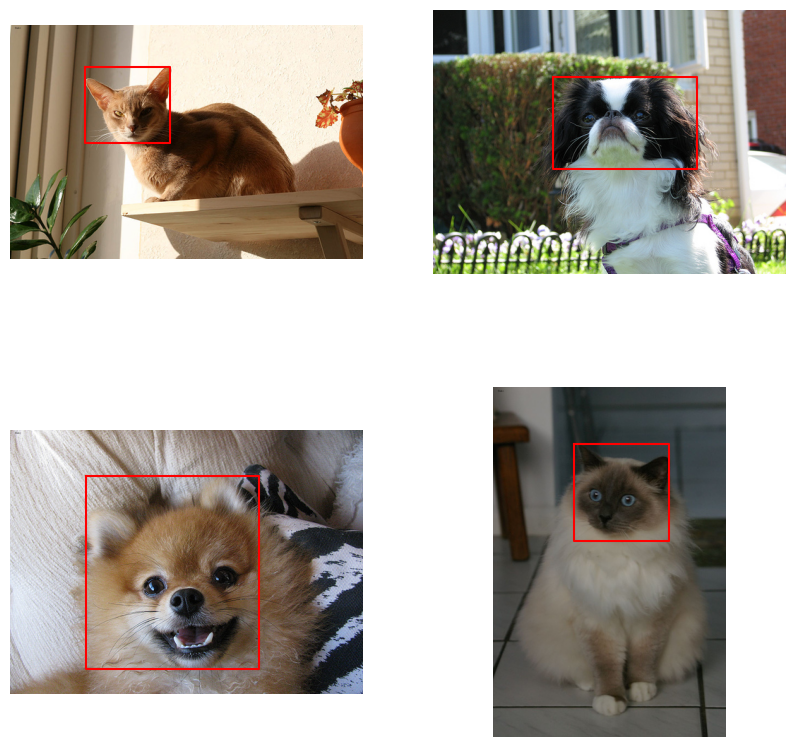

In [9]:
def get_bounding_box(index):
    filename = f"datasets/annotations/Cats_Test{index}.xml"
    tree = ET.parse(filename)
    root = tree.getroot()
    xml_box = root.find("object").find("bndbox")
    xmin = int(xml_box.find("xmin").text)
    ymin = int(xml_box.find("ymin").text)
    xmax = int(xml_box.find("xmax").text)
    ymax = int(xml_box.find("ymax").text)
    return [xmin, ymin, xmax, ymax]


# Lets look at a few examples
num_images = 3686
indices = np.random.randint(0, num_images, 4)
plt.subplots(2, 2, figsize=(10, 10))
for i, index in enumerate(indices):
    plt.subplot(2, 2, i + 1)
    img = Image.open(f"datasets/images/Cats_Test{index}.png")
    plt.imshow(img)
    xmin, ymin, xmax, ymax = get_bounding_box(index)
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], "r")
    plt.axis("off")
plt.show()


In [12]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = AutoModel.from_pretrained("facebook/dinov2-base")

In [84]:
def get_image(image_path):
    image = Image.open(image_path)
    # pad the image to the correct size
    longer_size_len = max(image.size)
    color = 0 if image.mode == "L" else (0, 0, 0, 0)
    image = ImageOps.pad(image, (longer_size_len, longer_size_len), color=color)
    return image


In [32]:
# create datasets X, y
X = []

batch_size = 32
for batch_start_i in tqdm.tqdm(range(0, num_images, batch_size)):
    batch_end_i = min(batch_start_i + batch_size, num_images)
    batch_images = [
        get_image(f"datasets/images/Cats_Test{i}.png")
        for i in range(batch_start_i, batch_end_i)
    ]
    inputs = processor(images=batch_images, return_tensors="pt")
    outputs = model(**inputs)
    X.extend(outputs["last_hidden_state"].detach().numpy())

X = np.array(X)

y = np.array(
    [
        get_bounding_box(i)
        for i in tqdm.tqdm(range(num_images))
    ]
)

# save datasets
np.save("datasets/preped/X.npy", X)
np.save("datasets/preped/y.npy", y)

100%|██████████| 3686/3686 [00:00<00:00, 7573.85it/s]


In [2]:
X = np.load("datasets/preped/X.npy")
y = np.load("datasets/preped/y.npy")

In [28]:
# split datasets (train, val, test)
indices = np.arange(len(X))
train_indices, test_indices = train_test_split(indices, test_size=0.2)
train_indices, val_indices = train_test_split(train_indices, test_size=0.2)

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [18]:
class ObjectDetector(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        """
        Initialize the ObjectDetector model.
        
        Parameters:
            input_dim (int): Dimension of the input feature vector (default: 768)
            hidden_dim (int): Dimension of the hidden layer (default: 256)
        """
        super(ObjectDetector, self).__init__()
        
        # Fully connected hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Output layer to predict the 4 bounding box coordinates
        self.fc2 = nn.Linear(hidden_dim, 4)
    
    def forward(self, x):
        """
        Forward pass for ObjectDetector.
        
        Parameters:
            x (torch.Tensor): Input feature tensor (last_hidden_state)
            
        Returns:
            torch.Tensor: Predicted bounding box coordinates
        """
        # Use the [CLS] token feature (assuming it's the first in the sequence)
        cls_feature = x[:, 0, :]

        # Pass through the hidden layer
        x = self.fc1(cls_feature)

        # Pass through the output layer
        x = self.fc2(x)
        
        return x

In [101]:
class ObjectDetectorGlobalAvgPooling(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        super(ObjectDetectorGlobalAvgPooling, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 4)

    def forward(self, x):
        # Average along the sequence dimension
        x_avg = torch.mean(x[:, 1:, :], dim=1)
        x = F.relu(self.fc1(x_avg))
        x = self.fc2(x)
        return x

In [115]:
class ObjectDetectorMaxPooling(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        """
        Initialize the ObjectDetector model with Max Pooling.
        
        Parameters:
            input_dim (int): Dimension of the input feature vector (default: 768)
            hidden_dim (int): Dimension of the hidden layer (default: 256)
        """
        super(ObjectDetectorMaxPooling, self).__init__()
        
        # Fully connected hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Output layer to predict the 4 bounding box coordinates
        self.fc2 = nn.Linear(hidden_dim, 4)
    
    def forward(self, x):
        """
        Forward pass for ObjectDetector.
        
        Parameters:
            x (torch.Tensor): Input feature tensor (last_hidden_state)
            
        Returns:
            torch.Tensor: Predicted bounding box coordinates
        """
        # Max pool along the sequence dimension (ignoring the CLS token if it's the first in the sequence)
        x_max, _ = torch.max(x[:, 1:, :], dim=1)
        
        # Pass through the hidden layer
        x = F.relu(self.fc1(x_max))
        
        # Pass through the output layer
        x = self.fc2(x)
        
        return x


In [127]:
class ObjectDetectorAttention(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256):
        super(ObjectDetectorAttention, self).__init__()
        self.attention = nn.Linear(input_dim, 1)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 4)

    def forward(self, x):
        # Calculate attention scores
        att_scores = torch.sigmoid(self.attention(x))
        # Apply attention scores to features
        x_weighted = torch.sum(x * att_scores, dim=1)
        x = F.relu(self.fc1(x_weighted))
        x = self.fc2(x)
        return x


In [128]:
object_detector = ObjectDetectorAttention()
# Choose an optimizer (Adam in this example)
optimizer = optim.Adam(object_detector.parameters(), lr=0.001)
# Choose a loss function (Mean Squared Error in this example)
criterion = nn.MSELoss()

In [129]:
def train_object_detector(
    model, train_loader, val_loader, optimizer, criterion, num_epochs=20
):
    train_losses = []
    val_losses = []

    # Set model to training mode
    model.train()

    for epoch in range(num_epochs):
        pbar = tqdm.tqdm(total=len(train_loader), position=0, leave=False)
        epoch_loss = 0

        # Training loop
        for i, (embeddings, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch+1} - Train Loss: {loss.item():.4f}")

        # Record average training loss for this epoch
        train_losses.append(epoch_loss / len(train_loader))

        # Validation loop
        model.eval()
        with torch.no_grad():
            epoch_loss = 0
            for i, (embeddings, labels) in enumerate(val_loader):
                outputs = model(embeddings)
                loss = criterion(outputs, labels.float())

                epoch_loss += loss.item()
                pbar.set_description(f"Epoch {epoch+1} - Val Loss: {loss.item():.4f}")

            # Record average validation loss for this epoch
            val_losses.append(epoch_loss / len(val_loader))

        pbar.close()

        # Reset to training mode for next epoch
        model.train()

    return train_losses, val_losses


train_losses, val_losses = train_object_detector(
    object_detector,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    num_epochs=50,
)


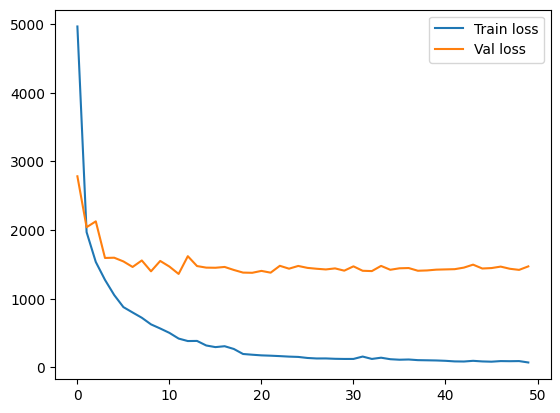

In [130]:
# Plot the training and validation losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()
plt.show()

In [131]:
min(val_losses)

1361.8569914165296

val loss results:
- CLS linear network: 2418
- average pooling: 1534
- max pooling: 2455
- attention: 1361

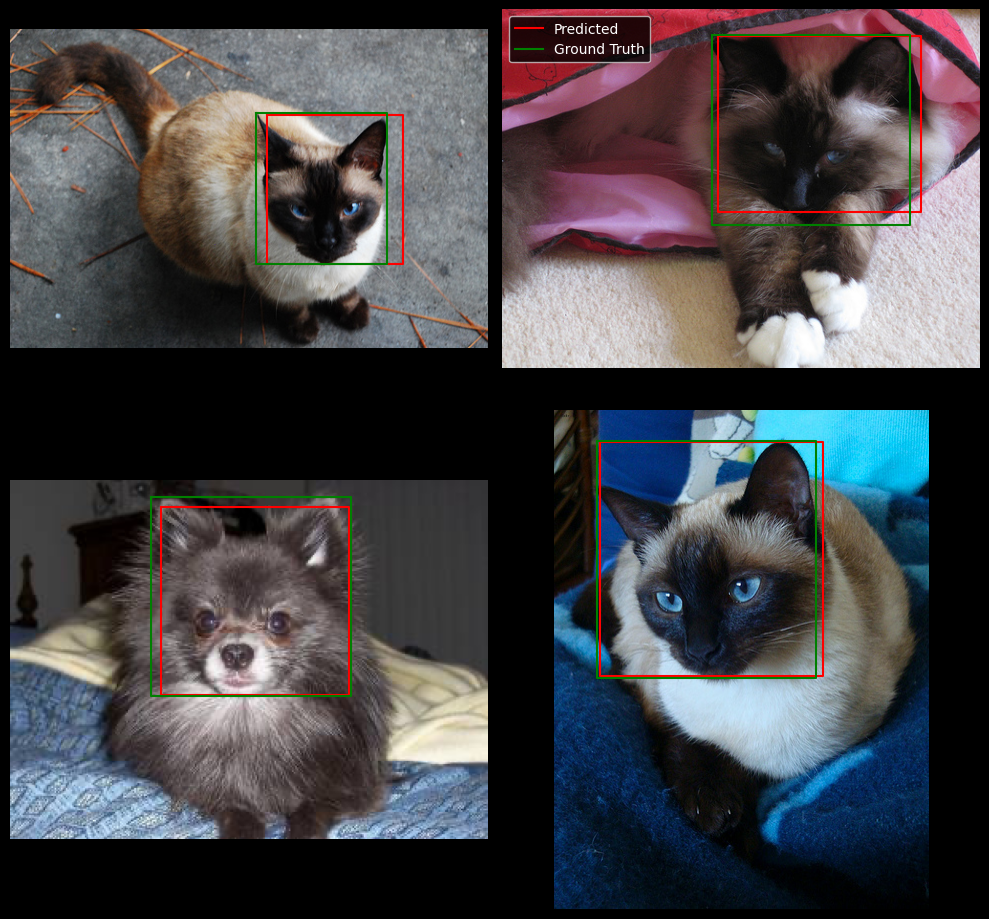

In [140]:
# Lets look at a few examples in the test set
sample_test_indices = random.sample(test_indices.tolist(), 4)

plt.subplots(2, 2, figsize=(10, 10))
for i, index in enumerate(sample_test_indices):
    X_i, y_i = X[index], y[index]
    pred_y = object_detector(torch.tensor(X_i).unsqueeze(0)).squeeze(0).detach().numpy()
    x_min, y_min, x_max, y_max = pred_y

    # plot image, ground truth bounding box, and predicted bounding box
    plt.subplot(2, 2, i + 1)
    img = Image.open(f"datasets/images/Cats_Test{index}.png")
    plt.imshow(img)
    plt.plot(
        [x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "r", label="Predicted"
    )
    x_min_t, y_min_t, x_max_t, y_max_t = y_i
    plt.plot(
        [x_min_t, x_max_t, x_max_t, x_min_t, x_min_t],
        [y_min_t, y_min_t, y_max_t, y_max_t, y_min_t],
        "g",
        label="Ground Truth",
    )
    plt.axis("off")

    if i == 1:
        plt.legend()

plt.tight_layout()
plt.style.use("dark_background")
plt.savefig("predictions.png")
plt.show()
